(20640, 9)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4  

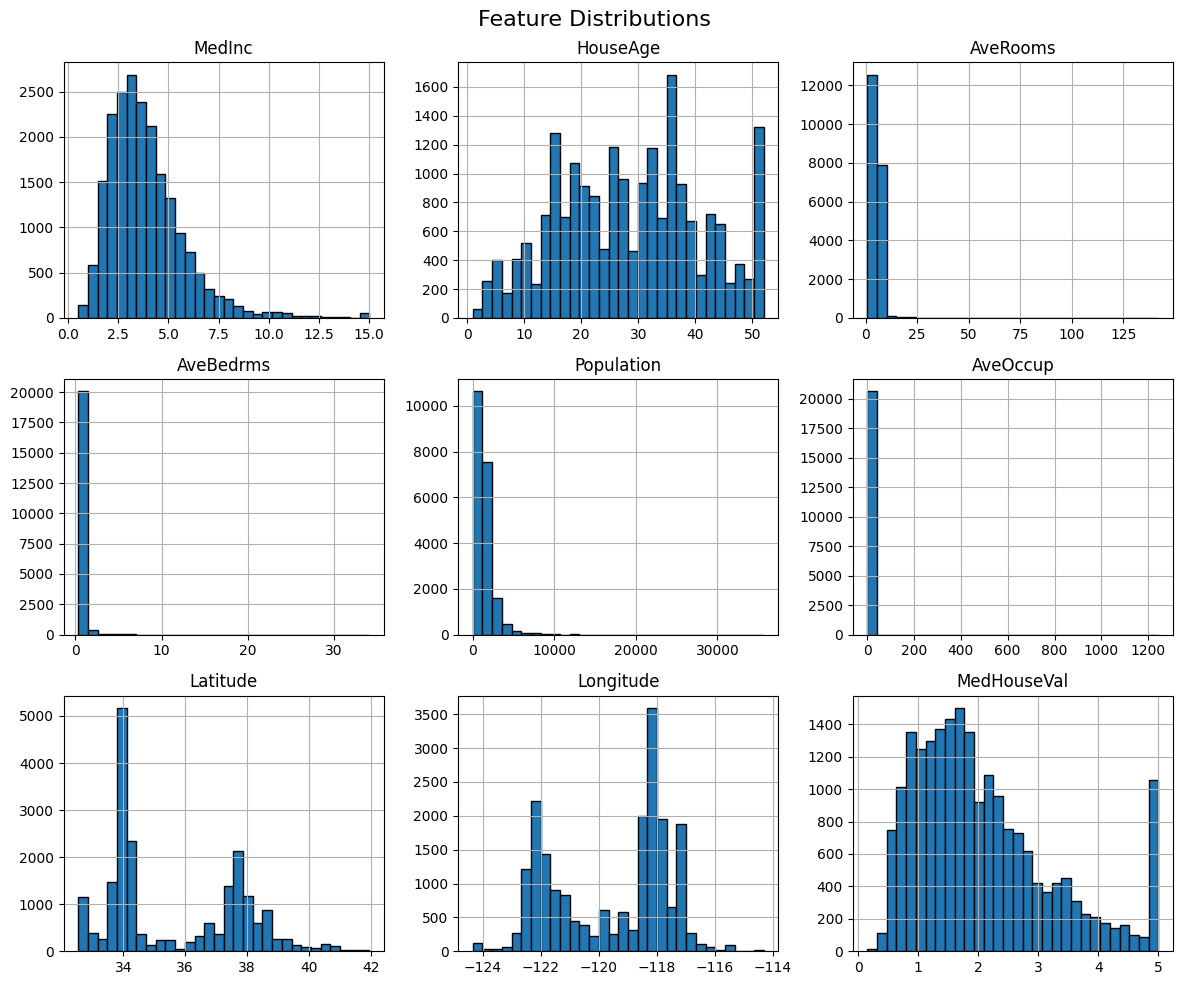

In [18]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = fetch_california_housing(as_frame=True)
df = data.frame

# Quick look
print(df.shape)
print(df.head())

# Summary info
print(df.info())
print(df.describe())

# Distribution of each feature
df.hist(bins=30, figsize=(12, 10), edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

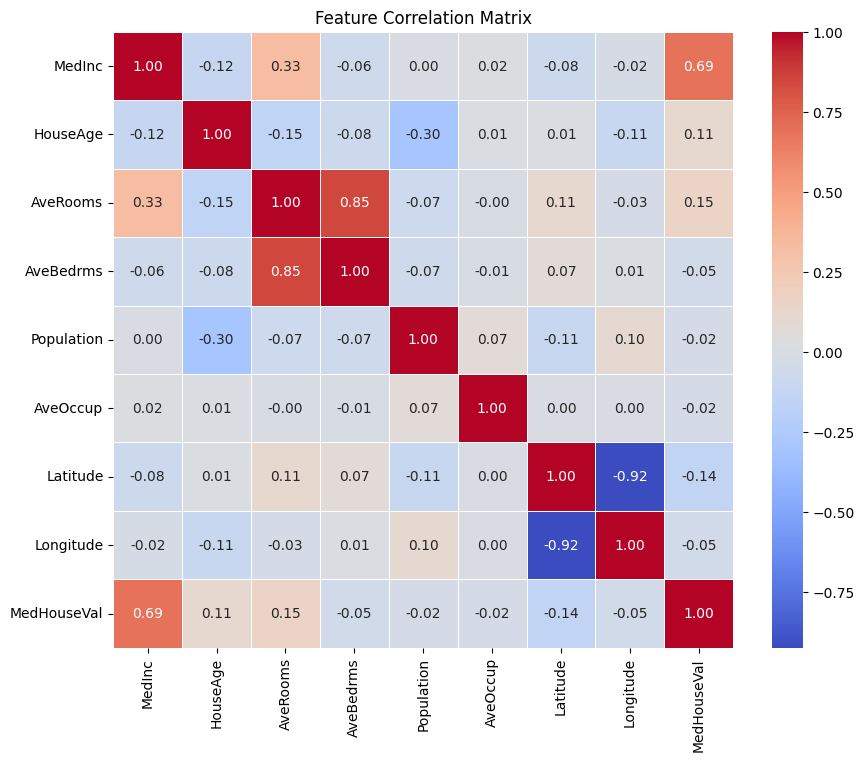

In [19]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Separate features and target
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# View learned coefficients
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(coefficients)

      Feature  Coefficient
3   AveBedrms     0.783145
0      MedInc     0.448675
7   Longitude    -0.433708
6    Latitude    -0.419792
2    AveRooms    -0.123323
1    HouseAge     0.009724
5    AveOccup    -0.003526
4  Population    -0.000002


MAE: 0.533
RMSE: 0.746
R² Score: 0.576


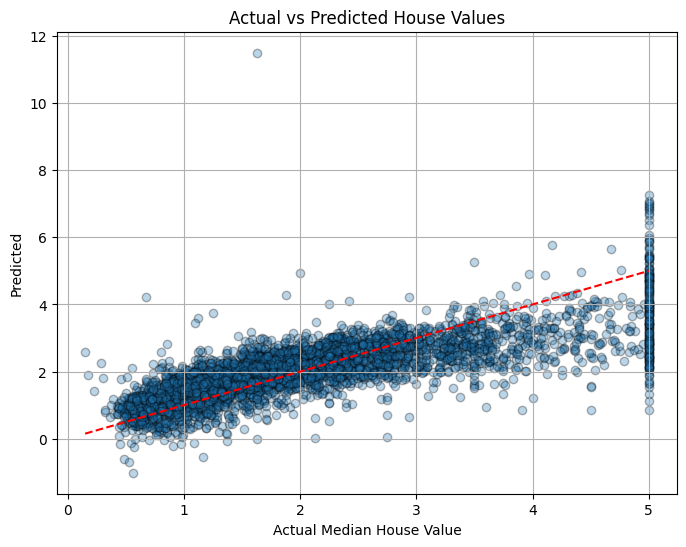

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted House Values")
plt.grid(True)
plt.show()

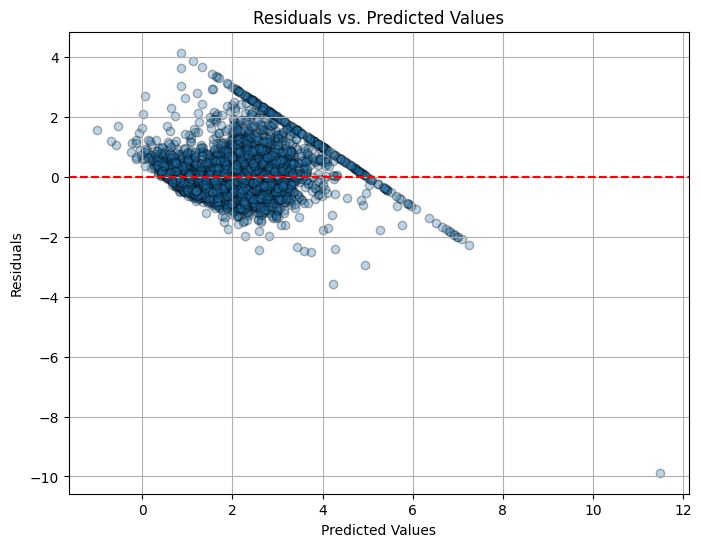

In [22]:
# Residuals = actual - predicted
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.3, edgecolors='black')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.show()

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to X (required for VIF)
X_const = add_constant(X)

# Compute VIF for each feature
vif_df = pd.DataFrame({
    "Feature": X_const.columns,
    "VIF": [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
})

print(vif_df.sort_values(by="VIF", ascending=False))

      Feature           VIF
0       const  17082.623698
7    Latitude      9.297624
8   Longitude      8.962263
3    AveRooms      8.342786
4   AveBedrms      6.994995
1      MedInc      2.501295
2    HouseAge      1.241254
5  Population      1.138125
6    AveOccup      1.008324


In [24]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Try multiple alpha (regularization strength) values
alphas = [0.01, 0.1, 1, 10, 100]
ridge_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X, y, cv=5, scoring='r2')
    ridge_scores.append(np.mean(scores))
    print(f"Ridge α={alpha}: R² (CV mean) = {np.mean(scores):.4f}")

# Best alpha
best_alpha_ridge = alphas[np.argmax(ridge_scores)]
print(f"\nBest Ridge α: {best_alpha_ridge}")

Ridge α=0.01: R² (CV mean) = 0.5530
Ridge α=0.1: R² (CV mean) = 0.5530
Ridge α=1: R² (CV mean) = 0.5530
Ridge α=10: R² (CV mean) = 0.5531
Ridge α=100: R² (CV mean) = 0.5534

Best Ridge α: 100


In [25]:
from sklearn.linear_model import Lasso

lasso_scores = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_val_score(lasso, X, y, cv=5, scoring='r2')
    lasso_scores.append(np.mean(scores))
    print(f"Lasso α={alpha}: R² (CV mean) = {np.mean(scores):.4f}")

best_alpha_lasso = alphas[np.argmax(lasso_scores)]
print(f"\nBest Lasso α: {best_alpha_lasso}")

Lasso α=0.01: R² (CV mean) = 0.5485
Lasso α=0.1: R² (CV mean) = 0.4722
Lasso α=1: R² (CV mean) = 0.2035
Lasso α=10: R² (CV mean) = -0.0939
Lasso α=100: R² (CV mean) = -0.0892

Best Lasso α: 0.01


In [26]:
# Fit Lasso with best alpha
final_lasso = Lasso(alpha=0.01, max_iter=10000)
final_lasso.fit(X_train, y_train)

# Coefficients table
lasso_coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": final_lasso.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(lasso_coeffs)

      Feature   Coefficient
7   Longitude -4.149332e-01
0      MedInc  4.088956e-01
6    Latitude -4.071099e-01
3   AveBedrms  3.633460e-01
2    AveRooms -4.744454e-02
1    HouseAge  1.030849e-02
5    AveOccup -3.359456e-03
4  Population -3.086013e-07
